# Jpeg Compression
---

Membres du groupe :
- Alexandre Blain
- Paul Corbalan
- Johan Lagardère
- Younès Loulidi

Département Génie Mathématique et Modélisation

INSA Toulouse

In [ ]:
import requests
from PIL import Image
import numpy as np
import heapq
from collections import defaultdict
from io import BytesIO
import imghdr
import matplotlib.pyplot as plt
import sys
from scipy.fft import dct, idct
import glob
import holoviews as hv
import panel as pn
hv.extension('bokeh')
from IPython.display import HTML
from flask import Flask, jsonify, request

In [ ]:
# Fonction pour récupérer l'image
def get_image_array(image_url):
    try:
        response = requests.get(image_url, headers={"User-Agent": "Scholarship_Project_Agent"})
        response.raise_for_status()  # Vérifier si la requête HTTP a réussi

        # Lire l'image à partir des données binaires
        image = Image.open(BytesIO(response.content))

        # Vérifier le format de l'image
        if imghdr.what(None, h=response.content) == "png":
            # Convertir l'image en tableau NumPy
            image_array = np.array(image)

            return image_array

        else:
            print("L'image n'est pas au format PNG.")
            return None

    except requests.exceptions.HTTPError as http_err:
        print(f"Erreur HTTP : {http_err}")
        return None
    except Exception as err:
        print(f"Erreur : {err}")
        return None

In [ ]:
# Source : https://commons.wikimedia.org/wiki/File:Lichtenstein_img_processing_test.png
image_url = "https://upload.wikimedia.org/wikipedia/commons/3/39/Lichtenstein_img_processing_test.png"
image = get_image_array(image_url)

if image is not None:
    plt.figure(figsize=(1,1))
    plt.imshow(image[:,:,:])

## Introduction



Les images bidimensionnelles, stockées sous format numérique, sont composées de millions de pixels, chacun représenté par une combinaison de bits. Ces images, qualifiées de bitmaps, diffèrent des images vectorielles qui utilisent des formules mathématiques pour créer des objets géométriques. Avec la demande croissante de qualité d'image et de vidéos, des efforts considérables ont été déployés pour augmenter la résolution dans laquelle les images sont stockées.

Par exemple, une image en 4K, soit une résolution de 3840×2160 pixels, stockée au format RAW/DNG avec une profondeur de couleur de 16 bits par pixel, nécessiterait environ 23 Mo pour être sauvegardée. Cela signifierait que 45 000 images occuperaient environ 1 To d'espace de stockage, augmentant la bande passante de transmission et le temps de transmission lors du partage de plusieurs images simultanément. De plus, l'hébergement d'images sur des serveurs web impliquerait également des coûts d'espace de stockage tout en augmentant les temps de chargement, compromettant ainsi l'expérience utilisateur.

À l'ère d'Internet, la compression des fichiers pour les partager avec d'autres utilisateurs est donc essentielle. Elle élimine cette nécessité d'un espace de stockage important en offrant des solutions efficaces pour le partage, la visualisation, et l'archivage d'un grand nombre d'images. Certains formats d'image génériques offrant une compression d'image sont le JPEG, le TIF, le GIF et le PNG. Mais c'est bien le format JPEG (Joint Photographic Experts Group) qui, depuis son introduction en 1992, est le format de compression d'image standard le plus utilisé dans le monde et a connu de nombreuses versions à travers les avancées des techniques d'images.

Ce projet traite des principes du codage et du décodage de base de JPEG, à travers des notions comme les bases de couleurs, la Transformée en Cosinus Discrète (DCT), le Run-Length Encoding (RLE), l'entropie d'une image ainsi que le codage de Huffman. Le premier objectif est d'utiliser l'algorithme sur une image et d'obtenir l'entropie de l'image avant et après le codage et décodage. Le second objectif est de tester notre algorithme sur un ensemble de plusieurs images afin de voir si l'entropie obtenue reste raisonnable. Le dernier objectif est enfin de créer une application pour utiliser notre algorithme et effectuer un codage-décodage qui génère, à partir d'une image source, le codage de Huffman en fichier texte ou bien l'image codée puis décodée par notre version de JPEG.

## Entropie

Dans la compression d'images, l'entropie est souvent utilisée pour décrire la quantité d'informations ou de détails présents dans une image. Plus précisément, elle est utilisée pour quantifier la quantité moyenne d'informations nécessaires pour représenter chaque pixel de l'image.

Dans la compression JPEG, le processus de quantification entraîne une perte d'informations, et l'entropie des données quantifiées est une mesure de la quantité d'informations perdues.

Une entropie plus faible indique généralement un niveau de compression plus élevé, car les données deviennent plus régulières et prévisibles, mais elle peut également entraîner une perte de détails fins et de qualité d'image.

L'entropie $H(X)$ est calculée comme $H(X) =  -\sum_{i} P(x_i) \log(P(x_i)) $ ou $P(x_{i})$ est la probabilité d'occurrence de la i-ème valeur unique du codage de huffman.

On comprend alors l'importance d'associer un code court à un élement ayant une fréquence d'apparition importante dans le codage de huffman. L'entropie telle que presenté ici est une notion théorique puisqu'on ne peut pas avoir la probabilité d'occurence d'un pixel, on peut donc l'approcher de la manière suivante :

In [ ]:
# Calcul de l'entropie
def calculate_entrop_t(image):
    if image.dtype != np.uint8:
      image = image.astype(np.uint8)
    image = image.flatten()  # Flatten the image to 1D array for histogram
    histogram = np.bincount(image, minlength=256)
    probabilities = histogram / len(image)  # Normalize to probabilities
    probabilities = probabilities[probabilities > 0]  # Exclude zero entries
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy


# Deux fonctions utiles pour revenir à la shape de l'image de base afin de calculer l'entropie efficacement
def unsub_cb(Cb_down):
  val_int = 0
  Cb=np.zeros((int(Cb_down.shape[0]*2),int(Cb_down.shape[1]*2)))
  for i in range(int(Cb_down.shape[0])):
    colonne_max = (i+1)*2-1
    for j in range(int(Cb_down.shape[1])):
      ligne_max = (j+1)*2-1
      val_int = Cb_down[i,j]
      Cb[colonne_max, ligne_max] = val_int
      Cb[colonne_max, ligne_max-1] = val_int
      Cb[colonne_max-1, ligne_max] = val_int
      Cb[colonne_max-1, ligne_max-1] = val_int
  return Cb


# Fonction pour revenir d'une combinaison de bloc à un channel d'une image
def combine_blocks(blocks, original_shape):

    block_size = blocks.shape[1]  # Taille du bloc
    num_blocks_height = original_shape[0] // block_size
    num_blocks_width = original_shape[1] // block_size

    # Reshape pour obtenir les blocs dans le format original
    reshaped_blocks = blocks.reshape(num_blocks_height, num_blocks_width, block_size, block_size)

    # Transposer les axes pour obtenir la forme correcte
    transposed_blocks = reshaped_blocks.transpose(0, 2, 1, 3)

    # Reshape pour obtenir l'image originale
    reconstructed_image = transposed_blocks.reshape(original_shape)

    return reconstructed_image

In [ ]:
entropy_image=calculate_entrop_t(image)
print("Entropie de l'image initiale : ", entropy_image)

## Base de couleur et sous-échantillonage


On considère des images d'entrées contenants 24 bits par pixel(8 rouges,verts et bleus) : codage RGB et on considère ici une méthode de compression où l'on va perdre des données.(lossy data compression method)

La conversion de l'espace colorimétrique RVB à YCbCr, élément préliminaire de la compression JPEG, est réalisée par les équations suivantes, où les composantes RVB (R, V, B) sont converties en luminance (Y), chrominance bleue (Cb) et chrominance rouge (Cr) :

\begin{equation}
Y = 0.3R+0.6V+0.11B
\end{equation}

\begin{align*}
Cb &= -0.17R +0.5B - 0.33V+128 \\
Cr &= 0.5R - 0.42V- 0.08B+128
\end{align*}

 L'utilisation d'un espace colorimétrique YCbCr permet d'optimiser la compression en exploitant les caractéristiques de perception visuelle humaine, où la sensibilité aux détails de chrominance est moindre par rapport à la luminance.

Une étape cruciale pour la compression est alors le sous-échantillonnage de la chrominance. Dans la norme JPEG, cela est défini par des schémas comme le 4:4:4, le 4:2:2 et le 4:2:0, influençant directement la quantité d'informations conservée pour la chrominance. En notations mathématiques, cela se traduit par une réduction des échantillons de chrominance dans chaque ligne d'une image. Par exemple, pour le schéma 4:2:0, où la chrominance est échantillonnée à la moitié de la résolution horizontale et verticale par rapport à la luminance.

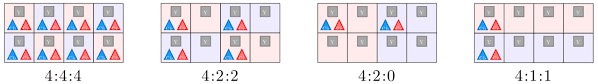

Cette réduction des échantillons de chrominance permet une diminution de la quantité d'informations sans altérer considérablement la qualité visuelle, un compromis crucial pour la compression.

In [ ]:
#sous-echantillonage 4:2:0
def sub_cr(Cb):
    Cb_down = np.zeros((int(Cb.shape[0]/2), int(Cb.shape[1]/2)))
    for i in range(0, Cb.shape[0], 2):
        for j in range(0, Cb.shape[1], 2):
            block = Cb[i:i+2, j:j+2]
            Cb_down[int(i/2), int(j/2)] = np.mean(block)
    return Cb_down

In [ ]:
# Image en output
V = image[:,:,0]
B = image[:,:,1]
R = image[:,:,2]

# Using coefficients of https://www.youtube.com/watch?v=Kv1Hiv3ox8I
Y=(0.3*R+0.6*V+0.11*B)
Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)

# Sous echantillonnage de l'image
Cb_down = sub_cr(Cb)
Cr_down = sub_cr(Cr)

In [ ]:
# Fonction de plot de plot des channels à chaque étapes
def plot_fig(obj, name):
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))
  for i, (k, j) in enumerate(zip(obj, name)):
    axs[i].imshow(k)
    axs[i].set_title(j)
  plt.tight_layout()
  plt.show()

In [ ]:
ent = calculate_entrop_t(np.concatenate((Y, unsub_cb(Cb_down), unsub_cb(Cr_down)))) #changement de shape pour revenir a la shape initial
plot_fig([Y, Cr_down, Cb_down], ['Image Y', 'Image Cr_down', 'Image Cb_down'])
print(f'L\'entropie après Changement de base et sous-échantillonage vaut {int(100*ent/entropy_image)}% de l\'entropie initiale')

## Découpage en bloc


Après le sous-échantillonnage, chaque canal doit être divisé en blocs de taille 8×8. En fonction du sous-échantillonnage chromatique réalisé, on obtient des blocs de Minimum Coded Unit (MCU) de taille 8×8 (4:4:4 - pas de sous-échantillonnage), 16×8 (4:2:2) ou, le plus souvent, 16×16 (4:2:0).

Il y a cependant une limitation à ce process si les données d'un canal ne représentent pas un nombre entier de blocs, il est alors nécessaire de remplir la zone restante des blocs incomplets avec des dummy datas. On peut alors faire un remplissage des bords avec une couleur fixe (par exemple, le noir) mais cela peut créer des ringing artifacts le long de la partie visible du bord. Une solution à ce problème est la répétition des pixels du bord qui est une technique courante réduisant mais n'éliminant pas nécessairement de tels artefacts.
Pour la suite de notre étude nous considérerons des blocs 8×8 de chaque canaux Y,Cb et Cr. On obtient un tableau où chaque ligne représente un bloc 8×8 , ce qui est une disposition pratique pour les étapes suivantes du processus de compression JPEG.


In [ ]:
def split_into_blocks_numpy(image_channel, block_size=8):

    height, width = image_channel.shape

    # Calculez le nombre de blocs en hauteur et en largeur
    num_blocks_height = -(-height // block_size)  # Round up division
    num_blocks_width = -(-width // block_size)  # Round up division

    # Paddage de l'image si nécessaire
    padded_height = num_blocks_height * block_size
    padded_width = num_blocks_width * block_size

    # Le mode="edge" permet de répéter les bords du bloc en cas de division non-entière
    padded_image = np.pad(image_channel, ((0, padded_height - height), (0, padded_width - width)), mode='edge')

    # Reshape pour obtenir les blocs
    blocks = padded_image.reshape(num_blocks_height, block_size, num_blocks_width, block_size)
    blocks = blocks.transpose(0, 2, 1, 3).reshape(-1, block_size, block_size)

    return blocks

Y_blocks = split_into_blocks_numpy(Y)
Cb_down_blocks=split_into_blocks_numpy(Cb_down)
Cr_down_blocks=split_into_blocks_numpy(Cr_down)
# Affichage pour le premier bloc de l'image
plot_fig([Y_blocks[1,:,:], Cr_down_blocks[1,:,:], Cb_down_blocks[1,:,:]], ['Y blocks', 'Cr_down_blocks', ' Cb_down_blocks'])

## Transformée en Cosinus Discrète



 La transformée en cosinus discrète nous permets alors de transformer une image en ses composantes élémentaires dans le domaine fréquentiel. Cela permet ainsi une représentation plus efficace des variations présentes à l'intérieur de l'image facilitant la compression des données tout en minimisant la perte de qualité visuelle.


La formule de la Transformée en Cosinus Discrète (DCT) pour un coefficient DCT unique dans un bloc NxN est donnée par :
$$
 F(u, v) = \frac{1}{4} C(u) C(v) \sum_{x=0}^{N-1}\sum_{y=0}^{N-1}f(x, y) \cos\left[\frac{(2x+1)u\pi}{2N}\right]\cos\left[\frac{(2y+1)v\pi}{2N}\right]
$$
Or on considère ici notre image comme étant découpé en bloc de taille 8 par 8. De plus  Les valeurs de pixels dans une image conventionnelle en niveaux de gris sont généralement comprises entre 0 et 255, où 128 est la valeur médiane.En soustrayant 128, on déplace cette médiane vers zéro, créant ainsi des valeurs positives et négatives. Cette transformation est importante pour la DCT, car elle facilite la représentation des basses et hautes fréquences.On aura alors dans le cadre de JPEG la formule suivante:
$$
 F(u, v) = \frac{1}{4} C(u) C(v)\sum_{x=0}^{7}\sum_{y=0}^{7}(f(x, y)-128)\cos\left[\frac{(2x+1)u\pi}{16}\right]\cos\left[\frac{(2y+1)v\pi}{16}\right]
$$

où :
- $u$ est la fréquence spatiale horizontale pour $0≤u< 8$
- $v$ est la fréquence spatiale verticale pour $0≤v< 8$
- $f(x, y)$ est la valeur du pixel dans le domaine spatial à la position $(x, y)$.
- $F(u, v)$ est le coefficient DCT dans le domaine fréquentiel à la position $(u, v)$.
- $C(u)$ et $C(v)$ sont des coefficients de mise à l'échelle qui dépendent des indices $u$ et $v$. Typiquement, $C(u)$ et $C(v)$ sont égaux à $\frac{1}{\sqrt{2}}$ pour u ou v égaux à zéro, et à $\frac{1}{2}$ pour les autres valeurs de $u$ et $v$. Ceci permet de rendre la transformation orthonormale.


Cette formule calcule le coefficient DCT pour une position spécifique $(u, v)$ dans le bloc 8x8 en faisant la somme du produit de chaque valeur de pixel $f(x, y)$ dans le bloc avec deux fonctions cosinus. La sommation est effectuée pour toutes les positions $x$ et $y$ dans le bloc.

Le coefficient DCT résultant $F(u, v)$ représente l'amplitude et la phase du composant de fréquence spatiale à la fréquence $(u, v)$ dans le bloc. Or L'humain perçoit mieux les basses fréquences (comme par exemple les séparations entre des textures différentes) que les hautes fréquences (comme l'arrière plan lisse ou les ombres) dans une image. C'est cette représentation fréquentielle qui permet à la DCT de réaliser une quantification sur les blocs en supprimant les hautes fréquences et c'est l'étape qui suit dans la compression Jpeg.


In [ ]:
def dct2D(x):
	tmp = dct(x, type=2 ,norm='ortho').transpose() # On fait une dct sur les colonnes puis on transpose
	return dct(tmp, type=2 ,norm='ortho').transpose() # On fait une dct sur les lignes puis on retranspose


Y_DCT=dct2D(Y_blocks)
Cb_down_DCT=dct2D(Cb_down_blocks)
Cr_down_DCT=dct2D(Cr_down_blocks)

# Fonction pour afficher de manière jolie les canaux
def plot_dct_channels(Y_DCT, Cb_down_DCT, Cr_down_DCT):
    # Créer une figure avec des sous-plots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Afficher le canal Y
    #on plot avec un log abs pour voir les valeurs faibles peu visible et pour un bloc particulier ici le 3ème bloc
    axes[0].imshow(np.log(np.abs(Y_DCT[3]) + 1), interpolation='nearest')
    axes[0].set_title('Y Channel')

    # Afficher le canal Cb
    axes[1].imshow(np.log(np.abs(Cb_down_DCT[3]) + 1), interpolation='nearest')
    axes[1].set_title('Cb Channel')

    # Afficher le canal Cr
    axes[2].imshow(np.log(np.abs(Cr_down_DCT[3]) + 1), interpolation='nearest')
    axes[2].set_title('Cr Channel')

    # Afficher la figure
    plt.show()


plot_dct_channels(Y_DCT, Cb_down_DCT, Cr_down_DCT)
ent_DCT=calculate_entrop_t(np.concatenate((combine_blocks(Y_DCT, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0))
print(f'Entropie après la DCT vaut {int(100*ent_DCT/entropy_image)}% de l\'entropie initiale')

## Quantification et filtrage haute fréquence



Après l’étape de la Transformée en Cosinus Discrète (DCT), nous poursuivons avec la seule phase non conservatrice du processus de compression JPEG : la quantification.

### Objectif de la quantification

Elle permet, moyennant une certaine perte de données et une diminution de la précision de l'image, de réduire le nombre de bits nécessaires au stockage.

### Fonctionnement théorique

Le processus de quantification fonctionne car il exploite le fait que l'œil a du mal à percevoir des hautes fréquences dans une image.

En effet, notre système visuel est bon pour détecter des variations de luminosité sur une grande surface (contours : basses fréquences), mais est médiocre pour détecter précisément ces mêmes changements sur une petite surface (détails : hautes fréquences). De plus, il arrive souvent que certaines zones soient un peu floues dans une image.

Dans les zones à hautes fréquences, retirer des variations de couleurs pour créer des textures plus lisses est donc imperceptible à l'œil nu.

### Fonctionnement pratique

En pratique pour la phase de quantification, comme pour l’étape de la DCT, l’algorithme parcourt chaque bloc d’image ($8 \times 8$ pixels) pour trouver des zones qui ont des hautes fréquences de chrominance ou de luminance, puis les enlève.

Plus précisément, la quantification réduit la précision des blocs d'image en réduisant davantage ceux qui contiennent des données à haute fréquence.

### Tables de quantification

L’algorithme crée des tables de quantification. Ce sont des matrices contenant des nombres entiers, petits dans le coin supérieur gauche (où l'œil peut facilement distinguer les motifs), puis plus grands dans le coin inférieur droit, là où se situent les zones à haute fréquence (que l'œil ne peut pas percevoir).

Par la suite, l'algorithme récupère la matrice des constantes (correspondant à l’utilisation de chaque image de base) obtenue suite à l’étape de la DCT, puis divise chaque valeur dans la matrice par la valeur correspondante dans la table de quantification, avant d’arrondir chaque résultat à l’entier le plus proche.

Après passage par la table de quantification, la matrice résultante contient beaucoup de zéros. Des données ont donc été perdues, mais il s’agit de données que l'œil ne peut pas percevoir, donc on ne voit pas de différence.

L’algorithme utilise trois tables de quantification :

- Deux pour la chrominance (chrominances rouge et bleue), qui contiennent des valeurs globalement plus grandes que dans celle de la luminance, qui renvoie donc une matrice résultante avec davantage de zéros ;
- Une pour la luminance, avec des valeurs plus petites, permettant de garder davantage de données (donc davantage de précision) dans la matrice résultante (en effet, comme vu au début, l'œil est beaucoup plus sensible aux variations de contrastes qu’aux variations de couleurs, d'où l'importance de conserver le plus d'informations ici).

### Tables classiques utilisées en JPEG

Les tables de quantification de base que nous allons utiliser dans ce projet ont été trouvées sur Internet : elles sont classiques et souvent utilisées pour la compression JPEG.

La table utilisée pour la luminance est :

$$T_Y = \begin{bmatrix}
    16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 \\
    12 & 12 & 14 & 19 & 26 & 40 & 51 & 61 \\
    14 & 13 & 15 & 20 & 25 & 38 & 51 & 60 \\
    14 & 17 & 19 & 22 & 29 & 44 & 55 & 64 \\
    18 & 21 & 26 & 34 & 37 & 52 & 61 & 66 \\
    24 & 26 & 32 & 40 & 48 & 58 & 66 & 70 \\
    29 & 34 & 39 & 48 & 56 & 64 & 72 & 76 \\
    42 & 49 & 54 & 64 & 70 & 77 & 81 & 83 \\
\end{bmatrix}.$$

La table utilisée pour les chrominances rouge et bleue est :

$$T_{Cr} = T_{Cb} = \begin{bmatrix}
    17 & 18 & 24 & 40 & 51 & 61 & 67 & 72 \\
    18 & 21 & 26 & 43 & 55 & 67 & 72 & 76 \\
    21 & 25 & 30 & 47 & 62 & 72 & 77 & 80 \\
    24 & 29 & 34 & 52 & 65 & 74 & 79 & 82 \\
    27 & 32 & 37 & 56 & 70 & 78 & 81 & 85 \\
    30 & 35 & 39 & 59 & 73 & 81 & 84 & 87 \\
    53 & 62 & 72 & 84 & 92 & 99 & 105 & 110 \\
    60 & 69 & 77 & 90 & 98 & 105 & 110 & 113 \\
\end{bmatrix}.$$


### Facteur de qualité

Il est possible de choisir le niveau de compression d’une image via un facteur de qualité. Ceci modifie par conséquent les termes présents dans les tables de quantification. Plus les termes sont élevés, plus la matrice résultante contiendra de zéros, et plus le fichier résultant sera petit. Cependant, avec un niveau de compression trop élevé, on obtient des artéfacts ou des taches floues sur les bords des blocs.

Sur Internet, nous avons trouvé une fonction très utilisée en compression JPEG. Elle permet d'ajuster les tables de quantification en fonction du facteur de qualité $\mathcal{Q} \in [1, 100]$.


In [ ]:
def quantize(block, quantization_matrix):
    quantized_block = np.round(np.divide(block, quantization_matrix)).astype(np.int64)
    return quantized_block



def dequantize(quantized_block, quantization_matrix):
    block = np.multiply(quantized_block, quantization_matrix)
    return block


# Tables de quantification classiques utilisées en JPEG
luma_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 40, 51, 61],
    [14, 13, 15, 20, 25, 38, 51, 60],
    [14, 17, 19, 22, 29, 44, 55, 64],
    [18, 21, 26, 34, 37, 52, 61, 66],
    [24, 26, 32, 40, 48, 58, 66, 70],
    [29, 34, 39, 48, 56, 64, 72, 76],
    [42, 49, 54, 64, 70, 77, 81, 83]
])

chroma_table = np.array([
    [17, 18, 24, 40, 51, 61, 67, 72],
    [18, 21, 26, 43, 55, 67, 72, 76],
    [21, 25, 30, 47, 62, 72, 77, 80],
    [24, 29, 34, 52, 65, 74, 79, 82],
    [27, 32, 37, 56, 70, 78, 81, 85],
    [30, 35, 39, 59, 73, 81, 84, 87],
    [53, 62, 72, 84, 92, 99, 105, 110],
    [60, 69, 77, 90, 98, 105, 110, 113]
])


# Les seuils sont basés sur des recommandations courantes pour le réglage de la qualité lors de la compression JPEG (Internet).
def quality_factor_matrix(quality, quantization_matrix):
    # Facteur de qualité entre 1 et 100
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality

    # On ajuste les tables de quantification en fonction du facteur de qualité
    q_factor_quantization_matrix = ((quantization_matrix * quality) + 50) / 100
    q_factor_quantization_matrix = np.clip(q_factor_quantization_matrix, 1, 255)

    return q_factor_quantization_matrix


def quantize_image(image, quantization_matrix):
  quantized = np.copy(image)
  lenght = len(image)
  for i in range(lenght):
    quantized[i]=quantize(image[i], quantization_matrix)
  return quantized

def dequantize_image(q_image, quantization_matrix):
  quantized = np.copy(q_image)
  lenght = len(q_image)
  for i in range(lenght):
    quantized[i]=dequantize(q_image[i], quantization_matrix)
  return quantized


quality = 100
Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))
plot_dct_channels(Y_quantized, Cb_quantized, Cr_quantized)
entropy_quantized=calculate_entrop_t(np.concatenate((combine_blocks(Y_quantized, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0))
print(f'Entropie après la quantification vaut {int(100*entropy_quantized/entropy_image)}% de l\'entropie initiale')

## Nouvelle métrique : Place mémoire
Dans cette phase, il n'y aura pas de modification de l'information existante, mais plutôt une réorganisation de celle-ci. Cette réorganisation sera quantifiée en estimant l'espace théorique nécessaire pour stocker ces objets de manière optimisée. Par exemple, un nombre binaire occupera 1 bit, tandis qu'un entier nécessitera 32 bits.

In [ ]:
def calculate_numpy_image_size(image):
    # Obtenir les dimensions de l'image
    height, width, channels = image.shape
    # Chaque pixel utilise 'channels' octets (typiquement 3 pour RGB)
    size_in_bytes = height * width * channels
    return size_in_bytes


def calculate_encrypted_data_size(encrypted_data):
    size_in_bytes = 0
    # La taille en bits est égale à la longueur de la chaîne
    size_in_bits = calculate_bin(encrypted_data)
    return size_in_bytes

def calculate_huffman_dict_size(huffman_dicts):
    key_size = 0
    value_size = 0
    for huffman_dict in huffman_dicts:
      for h in huffman_dict:
        for key, value in h.items():
            # Taille de la clé (entier) + taille de la valeur (chaîne binaire)
            key_size += 4 #4 octets par int et un int par key
            value_size += calculate_bin(value)  # value en binaire
    return key_size + value_size

def calculate_huffman(encoded_data, huffman_dicts):
  return calculate_encrypted_data_size(encoded_data)+calculate_huffman_dict_size(huffman_dicts)

def calculate_bin(value):
  return len(value)//8

## Entropy Encoding (RLE and Huffman Coding)


Tout d'abord, parlons du "**Run Lenght Encoding**" : RLE est une forme simple de compression de données où les séquences d'éléments identiques sont remplacées par une seule valeur de données ainsi que leur nombre d'occurences comme montrer dans l'exemple ci-contre:


\begin{equation*}
    [1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]
    \xrightarrow{\text{RLE}}
    [(1, 5), (2, 3), (3, 4)]
\end{equation*}

L'hypothèse étant que plus il existe de séquences identiques longues dans les objets que nous manipulons, plus nous gagnons de l'espace de stockage.  Or, si les étapes précedentes de filtrage et de quantification ont bien été realisé, nous devons avoir une séquence importante de $0$ à la fin de nos matrices.

Dans ce contexte, le parcours en zigzag apporte une optimisation significative. En réorganisant les coefficients DCT d'un bloc d'image selon un ordre en zigzag, cette méthode permet de regrouper les coefficients de basse fréquence, souvent réduits à zéro après la quantification, vers la fin de la matrice. Cette réorganisation crée des séquences plus longues de zéros, optimisant ainsi l'étape suivante de compression par le codage RLE (Run Length Encoding). Le RLE compresse ces longues séquences en représentant chaque séquence par une valeur et son nombre d'occurrences, ce qui est particulièrement efficace pour les longues séries de zéros. Enfin, l'encodage de Huffman tire parti de ces données compressées par RLE pour attribuer des codes binaires de longueur variable, assignant des codes plus courts aux éléments les plus fréquents, comme les séquences de zéros. Ainsi, le parcours en zigzag, en facilitant la création de séquences longues de zéros, joue un rôle essentiel dans l'optimisation de la taille des fichiers d'image, tout en préservant la qualité visuelle de l'image originale.

Finalement, la dernière étape de notre processus est le **codage de Huffman**.C'est une technique de compression sans perte (loss less)  qui attribue des codes binaires variables à chaque élement de la matrice, en fonction de leur fréquence d'apparition.

Dans le contexte du JPEG, nous commençons par analyser la fréquence d'apparition des coefficients de la transformée en cosinus discrète (DCT) pour chaque bloc de l'image.

Nous construisons ensuite un arbre de Huffman spécifique aux coefficients de la DCT. Chaque coefficient devient un symbole, et la fréquence d'apparition de chaque coefficient dans l'image guide la construction de l'arbre. Nous créons des codes en nous déplaçant de la racine de l'arbre vers chaque coefficient en fonction de sa fréquence. Si nous tournons à droite à un nœud, nous écrivons un 1, et si nous tournons à gauche, nous rajoutons un 0. Ce processus produit une table de codes de Huffman dans laquelle chaque symbole se voit attribuer un code binaire de sorte que le symbole le plus fréquent ait le code le plus court, tandis que le symbole le moins fréquent se voit attribuer le code le plus long. Voici un exemple pour illustrer (il en existe d'autres pour la même situation) :


**Etape 1 : Calcul des fréquences :**

\begin{array}{cccc}
\text{Coefficient} & \text{Fréquence} \\
A & 14  \\
B & 6  \\
C & 3  \\
D & 2 \\
\end{array}

**Etape 2 : Déterminer l'arbre de Huffman (table de codage) :**

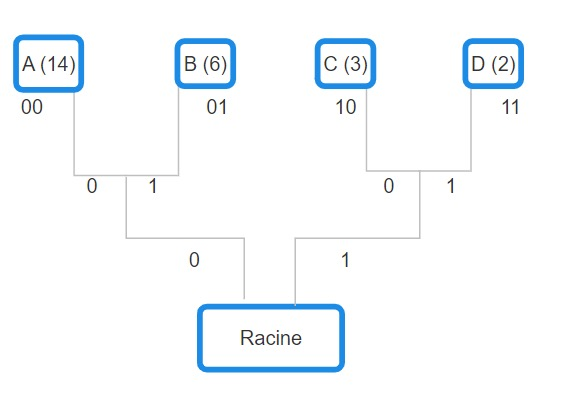

**Etape 3 : Codage:**

\begin{array}{cccc}
\text{Coefficient} & \text{Fréquence} & \text{Code Huffman} \\
A & 14 & 00\\
B & 6 & 01 \\
C & 3  &10 \\
D & 2 &11 \\
\end{array}

In [ ]:
def zigzag_order(matrix):
    # Obtient le nombre de lignes et de colonnes de la matrice
    rows, cols = matrix.shape

    # Initialisez une liste pour stocker le résultat du parcours en zigzag
    result = []

    # Parcourt de la diagonale supérieure gauche à la diagonale inférieure droite
    for i in range(rows + cols - 1):
        if i % 2 == 0:
            # Si l'indice est pair, parcourt de haut en bas sur la diagonale
            for j in range(max(0, i - cols + 1), min(rows, i + 1)):
                result.append(matrix[j][i - j])
        else:
            # Si l'indice est impair, parcourt de bas en haut sur la diagonale
            for j in range(min(i, rows - 1), max(0, i - cols + 1) - 1, -1):
                result.append(matrix[j][i - j])

    # Retourne la liste résultante
    return result


# Fonction pour encoder les valeurs RLE
def rle_encode(data):
    encoded_data = []
    count = 1
    for i in range(1, len(data)):
        # Utiliser np.all pour comparer tous les éléments
        if np.all(data[i] == data[i - 1]):
            count += 1
        else:
            encoded_data.append((data[i - 1], count))
            count = 1
    # Ajouter la dernière séquence
    encoded_data.append((data[-1], count))
    return encoded_data


# Fonction pour encoder les valeurs RLE avec Huffman
def huffman_encode(rle_data):
    # Création d'un dictionnaire pour compter la fréquence de chaque valeur
    frequency_dict = defaultdict(int)

    for value, count in rle_data:
        # Convertir les valeurs numpy.ndarray en tuples pour les rendre hachables
        if isinstance(value, np.ndarray):
            value = tuple(value)
        frequency_dict[value] += count

    # Création d'un tas (heap) à partir du dictionnaire de fréquence
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency_dict.items()]
    heapq.heapify(heap)

    # Si le tas n'a qu'un seul élément, lui assigner un code binaire fixe
    if len(heap) == 1:
        heap = [[heap[0][0], [heap[0][1][0], '0']]]

    # Combinaison des deux éléments les moins fréquents jusqu'à ce que le tas ne contienne qu'un seul élément
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Création d'un dictionnaire Huffman à partir de l'arbre
    huffman_dict = {symbol: code for symbol, code in heap[0][1:]}

    # Encodage des données RLE en utilisant le dictionnaire Huffman
    encoded_data = "".join(huffman_dict[tuple(value)] if isinstance(value, np.ndarray) else huffman_dict[value] for value, count in rle_data for _ in range(count))

    return encoded_data, huffman_dict

In [ ]:
def encode_blocks(blocks):
    zigzag_data, rle_data, encoded_data, huffman_dicts = [], [], [], []
    for block in blocks:
        # Zigzag Order
        zz_data = zigzag_order(block)
        zigzag_data.append(zz_data)

        # RLE Encode
        rle_data_block = rle_encode(zz_data)
        rle_data.append(rle_data_block)

        # Huffman Encode
        encoded_block, huffman_dict = huffman_encode(rle_data_block)
        encoded_data.append(encoded_block)
        huffman_dicts.append(huffman_dict)

    return encoded_data, huffman_dicts

In [ ]:
encoded_data = []
huffman_dicts = []

# Encoder les données Y
encoded_Y, huffman_Y = encode_blocks(Y_quantized)
encoded_data.append(encoded_Y)
huffman_dicts.append(huffman_Y)

# Encoder les données Cb
encoded_Cb, huffman_Cb = encode_blocks(Cb_quantized)
encoded_data.append(encoded_Cb)
huffman_dicts.append(huffman_Cb)

# Encoder les données Cr
encoded_Cr, huffman_Cr = encode_blocks(Cr_quantized)
encoded_data.append(encoded_Cr)
huffman_dicts.append(huffman_Cr)

Cette fonction réalise toutes les étapes de compréssion.

In [ ]:
def encode_image_to_huffman(image, quality = 100):
    V = image[:,:,0]
    B = image[:,:,1]
    R = image[:,:,2]

    Y=(0.3*R+0.6*V+0.11*B)
    Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
    Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)

    Cb_down = sub_cr(Cb)
    Cr_down = sub_cr(Cr)

    Y_blocks = split_into_blocks_numpy(Y)
    Cb_down_blocks=split_into_blocks_numpy(Cb_down)
    Cr_down_blocks=split_into_blocks_numpy(Cr_down)

    Y_DCT=dct2D(Y_blocks)
    Cb_down_DCT=dct2D(Cb_down_blocks)
    Cr_down_DCT=dct2D(Cr_down_blocks)

    Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
    Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
    Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))

    encoded_data = []
    huffman_dicts = []

    encoded_Y, huffman_Y = encode_blocks(Y_quantized)
    encoded_data.append(encoded_Y)
    huffman_dicts.append(huffman_Y)

    encoded_Cb, huffman_Cb = encode_blocks(Cb_quantized)
    encoded_data.append(encoded_Cb)
    huffman_dicts.append(huffman_Cb)

    encoded_Cr, huffman_Cr = encode_blocks(Cr_quantized)
    encoded_data.append(encoded_Cr)
    huffman_dicts.append(huffman_Cr)

    return encoded_data, huffman_dicts

Ici, nous allons compréssé l'image en encodage d'Huffman pour regarder la différence en terme de taille binaire.

In [ ]:
encoded_data, huffman_dicts = encode_image_to_huffman(image)

In [ ]:
print("Encodage d'Huffman :", encoded_data[0][0], sep = '\n', end = '\n---\n')
print("Dictionnaire d'Huffman :", huffman_dicts[0][0], sep = '\n', end = '\n---\n')
print(f'Taille du codage de Hauffman : {calculate_huffman(encoded_data, huffman_dicts)} octets')
print(f'Taille de l\'image de base : {calculate_numpy_image_size(image)} octets')
print(f'Pourcentage gagné : {100*calculate_numpy_image_size(image)/calculate_huffman(encoded_data, huffman_dicts)} %')

On observe division par 6,12 en terme de taille binaire entre l'image original et l'encodage d'Huffman avec le dictionnaire d'Huffman.

## Décodage



### Introduction au Décodage
Le décodage est l'étape finale du processus de visualisation des images et vidéos compressées. Après que les étapes de compression aient été appliquées pour réduire la taille des données, le décodage inverse ces étapes pour reconstruire l'image ou la vidéo originale. Ce processus est crucial pour assurer que l'image ou la vidéo puisse être affichée correctement sur différents appareils et plateformes.

### Décodage Entropique
#### Décodage de Huffman
Le codage de Huffman, comme présenté ci-dessus,  est une méthode de codage entropique qui utilise des codes de longueurs variables pour représenter les symboles selon leur fréquence. Lors du décodage, le processus est inversé en utilisant l'arbre de Huffman pour convertir les séquences de bits en symboles correspondants.

La formule de décodage de Huffman peut être représentée comme suit :

$$
S = \sum_{i=1}^{n} f_i \cdot l_i
$$

où $S$ est le symbole décodé, $f_i$ est la fréquence du symbole, et $l_i$ est la longueur du code pour le symbole.

#### Décodage RLE (Run-Length Encoding)
Le RLE est une forme simple de compression de données sans perte qui enregistre les séquences de données répétitives sous forme de paires de données et de compteurs. Pour décoder, chaque paire est lue et le symbole est répété le nombre de fois indiqué par le compteur.

Le processus de décodage RLE peut être exprimé comme :

$$
D = \bigcup_{i=1}^{n} (s_i \times c_i)
$$

où $D$ est le flux décodé, $s_i$ est le symbole, et $c_i$ est le nombre de répétitions.

### Quantification Inverse
La quantification inverse est le processus de multiplication de chaque coefficient DCT quantifié par son facteur de quantification associé pour restaurer les valeurs approximatives des coefficients DCT avant la quantification.

$$
\text{Coefficient DCT original} \approx \text{Coefficient DCT quantifié} \times \text{Facteur de quantification}
$$

### Transformée en Cosinus Discrète Inverse (IDCT)
La Transformée en Cosinus Discrète Inverse est utilisée pour convertir les coefficients DCT de retour dans le domaine spatial afin d'obtenir les blocs d'image approximatifs. La formule de l'IDCT pour une image bidimensionnelle de taille $N$ x $N$ est la suivante :

$$
f(x, y) = \frac{1}{4}  \sum_{u=0}^{N-1} \sum_{v=0}^{N-1} C(u) C(v)F(u, v) \cos\left[\frac{(2x+1)u\pi}{2N}\right] \cos\left[\frac{(2y+1)v\pi}{2N}\right]
$$
Or ici pour notre inversion on l'applique sur des blocs de taille 8 par 8 de même que pour le DCT on va ajouter pour ramener les valeurs des pixels à leur position d'origine. Cela permet de retrouver les valeurs d'origine des pixels dans l'image reconstruite.:
$$
f(x, y) = \frac{1}{4}  \sum_{u=0}^{7} \sum_{v=0}^{7}C(u) C(v)F(u, v) \cos\left[\frac{(2x+1)u\pi}{16}\right] \cos\left[\frac{(2y+1)v\pi}{16}\right]+128
$$
où :
- $x$ est la ligne de pixel pour les entiers $0≤x< 8$
- $y$ est la colonne de pixel pour les entiers $0≤y< 8$
- $f(x, y)$ est la valeur du pixel reconstruit à la position $(x, y)$.
- $F(u, v)$ est le coefficient DCT dans le domaine fréquentiel à la position $(u, v)$.
- $C(u)$ et $C(v)$ les facteurs de normalisations définis précédemment et cette fois-ci à l'intérieur de la somme.

Cette formule permet de reconstruire les valeurs des pixels dans l'image spatiale à partir des coefficients DCT correspondants dans le domaine fréquentiel, pour une image de taille $N$ x $N$.

### Reconstruction des Blocs d'Image
Après l'IDCT, les blocs d'image sont assemblés pour former l'image complète dans le format Y, Cb_down et Cr_down.

### Sous-échantillonnage inverse et Conversion de Couleur Inverse
La conversion de couleur inverse et le sous-échantillonnage inverse sont appliqués pour restaurer le format de couleur original de l'image. Cela implique généralement de passer du format YCbCr utilisé pour la compression au format RGB pour l'affichage.

### Synthèse de l'Image
Les blocs décodés sont intégrés pour reconstruire l'image complète. Cette étape peut également inclure des techniques de post-traitement pour réduire les artefacts de compression et améliorer la qualité visuelle de l'image.


### Étape 1: Décodage Huffman
Pour faire le décodage de Huffman, nous allons utiliser la fonction suivante, `huffman_decode` :

In [ ]:
def huffman_decode(encoded_data, huffman_dict):
    # Inverser le dictionnaire Huffman
    decode_dict = {code: symbol for symbol, code in huffman_dict.items()}

    decoded_values = []
    temp_code = ""
    for bit in encoded_data:
        temp_code += bit
        if temp_code in decode_dict:
            symbol = decode_dict[temp_code]
            decoded_values.append(symbol)
            temp_code = ""

    return decoded_values

### Étape 2: Décodage RLE
Ensuite, nous faisant décodage des données Run-Length Encoding (RLE). La fonction `rle_decode` est la suivante :

In [ ]:
def rle_decode(encoded_data):
    decoded_data = np.array([])
    for value, count in encoded_data:
        decoded_data = np.append(decoded_data, np.repeat(value, count))
    return decoded_data

### Étape 3: Déparcours Zigzag
La fonction suivante va nous permettre de parcourir à l'envers l'encodage RLE.

In [ ]:
def zigzag_decode(zigzag_data, rows, cols):
    matrix = [[0] * cols for _ in range(rows)]
    index = 0
    for i in range(rows + cols - 1):
        if i % 2 == 0:
            for j in range(max(0, i - cols + 1), min(rows, i + 1)):
                matrix[j][i - j] = zigzag_data[index]
                index += 1
        else:
            for j in range(min(i, rows - 1), max(0, i - cols + 1) - 1, -1):
                matrix[j][i - j] = zigzag_data[index]
                index += 1
    return matrix

À présent nous allons décoder les différents canaux.

In [ ]:
def decode_blocks(encoded_blocks, huffman_dicts, block_size = 8):
    decoded_blocks = []
    for block_index, encoded_block in enumerate(encoded_blocks):
        huffman_dict = huffman_dicts[block_index]

        # Huffman Decode
        rle_data = huffman_decode(encoded_block, huffman_dict)

        # Zigzag Reorder to Block
        block = zigzag_decode(rle_data, block_size, block_size)
        decoded_blocks.append(block)

    return decoded_blocks

In [ ]:
# Extraire les données encodées et les dictionnaires Huffman pour chaque composante
encoded_Y, encoded_Cb, encoded_Cr = encoded_data
huffman_Y, huffman_Cb, huffman_Cr = huffman_dicts

# Décoder les données Y
decoded_Y = decode_blocks(encoded_Y, huffman_Y)

# Décoder les données Cb
decoded_Cb = decode_blocks(encoded_Cb, huffman_Cb)

# Décoder les données Cr
decoded_Cr = decode_blocks(encoded_Cr, huffman_Cr)



### Étape 4: Déquantification

La déquantification peut être réalisée en utilisant la fonction inverse de la quantification :


In [ ]:
# "Requantification" de l'image, ici il on ne retrouve pas toute l'information

# La fonction a déja été définie dans la partie quantification
dequantized_Y = dequantize_image(decoded_Y, quality_factor_matrix(quality, luma_table))
dequantized_Cb = dequantize_image(decoded_Cb, quality_factor_matrix(quality, chroma_table))
dequantized_Cr = dequantize_image(decoded_Cr, quality_factor_matrix(quality, chroma_table))
plot_dct_channels(dequantized_Y, dequantized_Cb, dequantized_Cr)#pour le bloc 3



### Étape 5: IDCT (Inverse Discrete Cosine Transform)

Enfin, vous pouvez appliquer l'IDCT inverse pour obtenir l'image décodée :


In [ ]:
def idct2D(x):
    tmp = idct(x, type=2, norm='ortho').transpose()
    return idct(tmp, type=2, norm='ortho').transpose()


Y_IDCT_blocks=idct2D(dequantized_Y)
Cb_down_IDCT_blocks=idct2D(dequantized_Cb)
Cr_down_IDCT_blocks=idct2D(dequantized_Cr)
plot_dct_channels(Y_IDCT_blocks, Cb_down_IDCT_blocks, Cr_down_IDCT_blocks)#pour le bloc 3

### Étape 6: Bloc to image

In [ ]:
def combine_blocks(blocks, original_shape):

    block_size = blocks.shape[1]  # Taille du bloc
    num_blocks_height = original_shape[0] // block_size
    num_blocks_width = original_shape[1] // block_size

    # Reshape pour obtenir les blocs dans le format original
    reshaped_blocks = blocks.reshape(num_blocks_height, num_blocks_width, block_size, block_size)

    # Transposer les axes pour obtenir la forme correcte
    transposed_blocks = reshaped_blocks.transpose(0, 2, 1, 3)

    # Reshape pour obtenir l'image originale
    reconstructed_image = transposed_blocks.reshape(original_shape)

    return reconstructed_image


# Utilisez la fonction pour reconstituer l'image
Y_IDCT = combine_blocks(Y_IDCT_blocks, original_shape=(int(np.sqrt(Y_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Y_IDCT_blocks.shape[0]*8*8))))
Cb_down_IDCT = combine_blocks(Cb_down_IDCT_blocks, original_shape=(int(np.sqrt(Cb_down_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Cb_down_IDCT_blocks.shape[0]*8*8))))
Cr_down_IDCT = combine_blocks(Cr_down_IDCT_blocks, original_shape=(int(np.sqrt(Cr_down_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Cr_down_IDCT_blocks.shape[0]*8*8))))
plot_fig([Y_IDCT, Cb_down_IDCT, Cr_down_IDCT], ['Y_IDCT', 'Cb_down_IDCT', 'Cr_down_IDCT'])

### Étape 7: Décodage couleur

In [ ]:
def calculate_RGB(Y, Cb, Cr):
  R_result = 0.990 * Y  + 0.008 * (Cb - 128)+1.409*(Cr - 128)
  V_result =  0.990 * Y  -0.331 * (Cb - 128)-0.707*(Cr - 128)
  B_result =  0.990 * Y  +1.784 * (Cb - 128)+0.013*(Cr - 128)
  return(R_result,V_result,B_result)


un_cb = unsub_cb(Cb_down_IDCT)
un_cr = unsub_cb(Cr_down_IDCT)

# Calcul des composantes RVB
R_result, V_result, B_result = calculate_RGB(Y_IDCT, un_cb, un_cr)

plot_fig([R_result, V_result, B_result], ['Image R', 'Image V', 'image B'])

## Comparaison image originale et image codé/décodé:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
image_result=np.stack([ V_result, B_result,R_result],axis=-1)
axs[0].imshow(image.astype(int))
axs[0].set_title('Image Original')
axs[1].imshow(image_result.astype(int))
axs[1].set_title('Image Result')

plt.tight_layout()
plt.show()

### Décodage en une fonction

In [ ]:
def decode_huffman_to_image(encoded_data, huffman_dicts, quality = 100):
    # Extraire les données encodées et les dictionnaires Huffman pour chaque composante
    encoded_Y, encoded_Cb, encoded_Cr = encoded_data
    huffman_Y, huffman_Cb, huffman_Cr = huffman_dicts

    # Décoder les données Y
    decoded_Y = decode_blocks(encoded_Y, huffman_Y)

    # Décoder les données Cb
    decoded_Cb = decode_blocks(encoded_Cb, huffman_Cb)

    # Décoder les données Cr
    decoded_Cr = decode_blocks(encoded_Cr, huffman_Cr)

    # La fonction a déja été définie dans la partie quantification
    dequantized_Y = dequantize_image(decoded_Y, quality_factor_matrix(quality, luma_table))
    dequantized_Cb = dequantize_image(decoded_Cb, quality_factor_matrix(quality, chroma_table))
    dequantized_Cr = dequantize_image(decoded_Cr, quality_factor_matrix(quality, chroma_table))

    Y_IDCT_blocks=idct2D(dequantized_Y)
    Cb_down_IDCT_blocks=idct2D(dequantized_Cb)
    Cr_down_IDCT_blocks=idct2D(dequantized_Cr)

    Y_IDCT = combine_blocks(Y_IDCT_blocks, original_shape=(int(np.sqrt(Y_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Y_IDCT_blocks.shape[0]*8*8))))
    Cb_down_IDCT = combine_blocks(Cb_down_IDCT_blocks, original_shape=(int(np.sqrt(Cb_down_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Cb_down_IDCT_blocks.shape[0]*8*8))))
    Cr_down_IDCT = combine_blocks(Cr_down_IDCT_blocks, original_shape=(int(np.sqrt(Cr_down_IDCT_blocks.shape[0]*8*8)), int(np.sqrt(Cr_down_IDCT_blocks.shape[0]*8*8))))

    un_cb = unsub_cb(Cb_down_IDCT)
    un_cr = unsub_cb(Cr_down_IDCT)

    # Calcul des composantes RVB
    R_result, V_result, B_result = calculate_RGB(Y_IDCT, un_cb, un_cr)

    image_result=np.stack([ V_result, B_result,R_result],axis=-1)

    return image_result

In [ ]:
encoded_data, huffman_dicts = encode_image_to_huffman(image)
image_result = decode_huffman_to_image(np.array(encoded_data, dtype='object'), np.array(huffman_dicts, dtype='object'))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
image_result=np.stack([ V_result, B_result,R_result],axis=-1)
axs[0].imshow(image.astype(int))
axs[0].set_title('Image Original')
axs[1].imshow(image_result.astype(int))
axs[1].set_title('Image Result')

plt.tight_layout()
plt.show()

## Pour aller plus loin
### Test pour plusieurs seuils de qualités

In [ ]:
def load_images(folder_path = "images"):
    image_paths = glob.glob(f"{folder_path}/*.png")

    images = {}

    for image_path in image_paths:
        image_name = image_path.split("/")[-1]
        image = np.array(Image.open(image_path))
        images[image_name] = image

    return images

In [ ]:
def get_images_variables_for_entropy(images = load_images(folder_path = "images"), quality = 100):
    images_variables = {}

    for image_name, image in images.items():
        #image en output
        V = image[:,:,0]
        B = image[:,:,1]
        R = image[:,:,2]
        #using coefficients of https://www.youtube.com/watch?v=Kv1Hiv3ox8I
        Y=(0.3*R+0.6*V+0.11*B)
        Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
        Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)
        #sous echantillonnage de l'image
        Cb_down = sub_cr(Cb)
        Cr_down = sub_cr(Cr)

        Y_blocks = split_into_blocks_numpy(Y)
        Cb_down_blocks=split_into_blocks_numpy(Cb_down)
        Cr_down_blocks=split_into_blocks_numpy(Cr_down)

        Y_DCT=dct2D(Y_blocks)
        Cb_down_DCT=dct2D(Cb_down_blocks)
        Cr_down_DCT=dct2D(Cr_down_blocks)

        Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
        Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
        Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))

        encoded_data = []
        huffman_dicts = []

        # Encoder les données Y
        encoded_Y, huffman_Y = encode_blocks(Y_quantized)
        encoded_data.append(encoded_Y)
        huffman_dicts.append(huffman_Y)

        # Encoder les données Cb
        encoded_Cb, huffman_Cb = encode_blocks(Cb_quantized)
        encoded_data.append(encoded_Cb)
        huffman_dicts.append(huffman_Cb)

        # Encoder les données Cr
        encoded_Cr, huffman_Cr = encode_blocks(Cr_quantized)
        encoded_data.append(encoded_Cr)
        huffman_dicts.append(huffman_Cr)

        # Récupérer l'image décodée
        image_result = decode_huffman_to_image(encoded_data, huffman_dicts)

        # Stocker les informations dans le dictionnaire
        images_variables[image_name] = {
            "Image originale": image,
            "Changement base couleur": np.concatenate((Y.flatten(), Cb.flatten(), Cr.flatten()), axis=0),
            "Sous-échantillonage": np.concatenate((Y.flatten(), unsub_cb(Cb_down).flatten(), unsub_cb(Cr_down).flatten()), axis=0),
            "DCT": np.concatenate((combine_blocks(Y_DCT, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_down_DCT, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0),
            "Quantification": np.concatenate((combine_blocks(Y_quantized, original_shape = (int(image.shape[0]), int(image.shape[1]))), unsub_cb(combine_blocks(Cb_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2)))), unsub_cb(combine_blocks(Cr_quantized, original_shape = (int(image.shape[0]/2), int(image.shape[1]/2))))), axis=0),
            "Image décodée": image_result
        }

        return images_variables


def get_images_variables_entropy(images_variables):
    images_variables_entropy = {}

    for image_name, image_data in images_variables.items():
        images_variables_entropy[image_name] = {}
        for key, value in image_data.items():
            images_variables_entropy[image_name][key] = calculate_entrop_t(value)

    return images_variables_entropy


# Fonction pour tracer le graphique en barres en fonction de l'image et de la qualité
def plot_entropy(image_name, quality):
    images_variables = get_images_variables_for_entropy(images, quality)
    images_variables_entropy = get_images_variables_entropy(images_variables)

    image_data = images_variables_entropy[image_name]

    # Extraction des noms des composantes et de leurs entropies
    components = list(image_data.keys())
    entropies = [image_data[component] for component in components]

    # Calculer le pourcentage de l'entropie par rapport à l'entropie de l'image originale
    original_entropy = image_data['Image originale']
    entropies_percentage = [entropy / original_entropy * 100 for entropy in entropies]

    # Création du bar plot pour l'image sélectionnée
    bar_plot = hv.Bars((components, entropies_percentage)).opts(
        xlabel='Composantes de l\'image', ylabel='Entropie en pourcentage de l\'image originale',
        title=f'Entropie des composantes pour {image_name}', width=600, height=400,
        xrotation=45, tools=['hover'])

    return bar_plot

In [ ]:
def get_images_variables_for_byte(images = load_images(folder_path = "images"), quality = 100):
    images_variables = {}

    for image_name, image in images.items():
        #image en output
        V = image[:,:,0]
        B = image[:,:,1]
        R = image[:,:,2]
        #using coefficients of https://www.youtube.com/watch?v=Kv1Hiv3ox8I
        Y=(0.3*R+0.6*V+0.11*B)
        Cb =np.array(-0.17*R +0.5 *B - 0.33*V+128)
        Cr =np.array( 0.5*R - 0.42*V- 0.08*B+128)
        #sous echantillonnage de l'image
        Cb_down = sub_cr(Cb)
        Cr_down = sub_cr(Cr)

        Y_blocks = split_into_blocks_numpy(Y)
        Cb_down_blocks=split_into_blocks_numpy(Cb_down)
        Cr_down_blocks=split_into_blocks_numpy(Cr_down)

        Y_DCT=dct2D(Y_blocks)
        Cb_down_DCT=dct2D(Cb_down_blocks)
        Cr_down_DCT=dct2D(Cr_down_blocks)

        Y_quantized = quantize_image(Y_DCT, quality_factor_matrix(quality, luma_table))
        Cb_quantized = quantize_image(Cb_down_DCT, quality_factor_matrix(quality, chroma_table))
        Cr_quantized = quantize_image(Cr_down_DCT, quality_factor_matrix(quality, chroma_table))

        encoded_data = []
        huffman_dicts = []

        # Encoder les données Y
        encoded_Y, huffman_Y = encode_blocks(Y_quantized)
        encoded_data.append(encoded_Y)
        huffman_dicts.append(huffman_Y)

        # Encoder les données Cb
        encoded_Cb, huffman_Cb = encode_blocks(Cb_quantized)
        encoded_data.append(encoded_Cb)
        huffman_dicts.append(huffman_Cb)

        # Encoder les données Cr
        encoded_Cr, huffman_Cr = encode_blocks(Cr_quantized)
        encoded_data.append(encoded_Cr)
        huffman_dicts.append(huffman_Cr)

        # Récupérer l'image décodée
        image_result = decode_huffman_to_image(encoded_data, huffman_dicts)

        # Stocker les informations dans le dictionnaire
        images_variables[image_name] = {
            "Image originale": image,
            "Encodage d'Huffman": (encoded_data, huffman_dicts),
            "Image décodée": image_result
        }

        return images_variables


def get_images_variables_byte(images_variables):
    images_variables_byte = {}

    for image_name, image_data in images_variables.items():

        # Stocker les informations dans le dictionnaire
        images_variables_byte[image_name] = {
            "Image originale": calculate_numpy_image_size(image_data["Image originale"]),
            "Encodage d'Huffman": calculate_huffman(image_data["Encodage d'Huffman"][0], image_data["Encodage d'Huffman"][1]),
            "Image décodée": calculate_numpy_image_size(image_data["Image décodée"])
        }


    return images_variables_byte


# Fonction pour tracer le graphique en barres en fonction de l'image et de la qualité
def plot_byte(image_name, quality):
    images_variables = get_images_variables_for_byte(images, quality)
    images_variables_byte = get_images_variables_byte(images_variables)

    image_data = images_variables_byte[image_name]

    # Extraction des noms des composantes et de leurs bytes
    components = list(image_data.keys())
    bytes = [image_data[component] for component in components]

    # Calculer le pourcentage de l'entropie par rapport à l'entropie de l'image originale
    original_byte = image_data['Image originale']
    bytes_percentage = [byte / original_byte * 100 for byte in bytes]

    # Création du bar plot pour l'image sélectionnée
    bar_plot = hv.Bars((components, bytes_percentage)).opts(
        xlabel='Composantes de l\'image', ylabel='Entropie en pourcentage de l\'image originale',
        title=f'Entropie des composantes pour {image_name}', width=600, height=400,
        xrotation=45, tools=['hover'])

    return bar_plot

In [ ]:
images = load_images(folder_path="images")
quality_slider = pn.widgets.IntSlider(name='Qualité', start=50, end=100, step=5, value=100)
dropdown = pn.widgets.Select(name='Choisissez une image', options=list(images.keys()))
@pn.depends(dropdown.param.value, quality_slider.param.value)
def update_plot(image_name, quality):
    return plot_entropy(image_name, quality)
layout = pn.Row(pn.Column(dropdown, quality_slider), update_plot)
layout.servable()

In [ ]:
images = load_images(folder_path="images")
quality_slider = pn.widgets.IntSlider(name='Qualité', start=50, end=100, step=5, value=100)
dropdown = pn.widgets.Select(name='Choisissez une image', options=list(images.keys()))
@pn.depends(dropdown.param.value, quality_slider.param.value)
def update_plot(image_name, quality):
    return plot_byte(image_name, quality)
layout = pn.Row(pn.Column(dropdown, quality_slider), update_plot)
layout.servable()

### Extension Google Chrome

Cette extension pour Google Chrome a été développée en utilisant un serveur backend Flask. Cette approche technique facilite l'intégration et l'utilisation des fonctions de codage et de décodage JPEG précédemment développées, directement au sein d'une extension pour le navigateur Google Chrome.

In [ ]:
from flask import Flask, request, send_file
from PIL import Image
import numpy as np
import json
import io

#cette application ne devrait que fonctionner en locale
#création du serveur
app = Flask(__name__)

#definition des requetes du serveur
@app.route('/upload', methods=['POST']) #requete de codage: return le code de huffman avec l'encrypted data
def upload():
    file = request.files['image']
    image = Image.open(file.stream)
    image_array = np.array(image)
    image_shape = image_array.shape

    encoded_data, huffman_dicts, list_result = encode_image_to_huffman(image_array)
    result = list_result[0] - list_result[1]

    huffman_json = json.dumps(huffman_dicts)
    encoded_data_json = json.dumps(encoded_data)
    image_shape_json = json.dumps(image_shape)

    combined_data = f"{encoded_data_json}split{huffman_json}split{image_shape_json}split{result}"
    return combined_data

@app.route('/decode', methods=['POST']) #requete de décodage: return l'image initial'
def decode():
    file = request.files['file']

    content = file.read().decode('utf-8')
    parts = content.split('split')
    if len(parts) != 4:
        return "Invalid file format or delimiter not found.", len(parts)

    encoded_data_json, huffman_json, image_shape_json, _ = parts

    encoded_data = json.loads(encoded_data_json)
    huffman_dict = json.loads(huffman_json)
    image_shape = json.loads(image_shape_json)

    image_array = decode_huffman_to_image(np.array(encoded_data, dtype='object'), np.array(huffman_dict, dtype='object'), image_shape)
    image_array = np.clip(image_array, 0, 255)

    # Convert to uint8
    image_array = image_array.astype('uint8')
    img = Image.fromarray(image_array)
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()

    return send_file(
        io.BytesIO(img_byte_arr),
        as_attachment=True,
        download_name='decoded_image.png',
        mimetype='image/png'
    )

#lancement de l'application
if __name__ == "__main__":
    app.run(host='0.0.0.0', port=5000, debug=False)

In [ ]:
#code JavaScript de l'application

document.getElementById('uploadButton').addEventListener('click', function(){ #fonction de codage de l'image
    var file = document.getElementById('imageInput').files[0];
    var formData = new FormData();
    formData.append("image", file);

    fetch('http://localhost:5000/upload', { #requete à notre serveur précédemment crée
        method: 'POST',
        body: formData
    })
    .then(response => response.text())
    .then(code => {

        var lastIndexOfT = code.lastIndexOf('t'); #processing de la réponse du serveur (séparation des différents élements de la chaine de caratère)
        var extractedSubstring = code.slice(lastIndexOfT + 1);
        var formattedSubstring = Number(extractedSubstring).toLocaleString();

        var lastCharacterDisplay = document.getElementById('lastCharacterDisplay');
        lastCharacterDisplay.textContent = 'Gain de place en octets: ' + formattedSubstring; #affichage du gain de place en octets


        var downloadLink = document.getElementById('downloadLinkTXT'); #lien de téléchargement pour l'objet final
        downloadLink.href = 'data:text/plain;charset=utf-8,' + encodeURIComponent(code);
        downloadLink.download = 'huffman_code.txt';
        downloadLink.style.display = 'block';
    });
});

document.getElementById('decodeButton').addEventListener('click', function(){ #fonction de décodage de l'image
    var file = document.getElementById('imageInput').files[0];
    // Prepare the file to be sent as form data
    var formData = new FormData();
    formData.append("file", file);

    fetch('http://localhost:5000/decode', {
        method: 'POST',
        body: formData
    })
    .then(response => response.blob())
    .then(blob => {
        // Create an object URL for the blob
        var url = URL.createObjectURL(blob);
        // Create a download link for the image
        var downloadLink = document.getElementById('downloadLinkIMG');
        downloadLink.href = url;
        downloadLink.download = 'decoded_image.png';
        downloadLink.style.display = 'block';
    })
    .catch(error => {
        console.error('Error:', error);
    });
});